In [2]:
using PyPlot

using QuantumOptics
using LinearAlgebra
using Interpolations
using SplitApplyCombine
using DifferentialEquations
using SimpleDiffEq

#Random number generation
using Statistics
using Distributions
using Random

#Physical constants
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful

#Read and write CSV files
using DataFrames
using CSV

#Check time left to execute and benchmark functions
using ProgressMeter
using BenchmarkTools

In [3]:
include("../src/atom_sampler.jl");
include("../src/lasernoise_sampler.jl");
include("../src/utilities.jl");
include("../src/rydberg_model.jl");

### Description

$\hat{H} = -\Delta(t) \hat{n}_p - \delta(t) \hat{n}_r + \frac{\Omega_r(t)}{2} e^{i \phi_r(t)}\hat{\sigma}_{gp}+ \frac{\Omega_b(t)}{2}e^{i \phi_b(t)}\hat{\sigma}_{pr}+h.c.$

- $\phi_r(t), \phi_b(t)$ - phase noise from red and blue laser


- $\Omega_r(t), \Omega_b(t)$ - atom dynamics and laser amplitude noise


- $\Delta(t), \delta(t)$ - Doppler shifts for red and blue laser


- $\left| g \right>,\left| p \right>,\left| r \right>, \left| gt \right>$ - basis

__Params__

atom_params = [$m, T$]


trap_params = [$U_0, w_0, z_0$]

___

red_laser_params = [$ \Omega_0^{(r)}, w_0^{(r)}, z_0^{(r)}$]

blue_laser_params = [$ \Omega_0^{(b)}, w_0^{(b)}, z_0^{(b)}$]

___
red_laser_phase_params = [$h_0^{(r)}, h_g^{(r)}, \sigma_g ^{(r)}, f_g^{(r)}$]

blue_laser_phase_params = [$h_0^{(b)}, h_g^{(b)}, \sigma_g ^{(b)}, f_g^{(b)}$]
___

detuning_params = [$\Delta_0, \delta_0$]


decay_params = [$\Gamma_g, \Gamma_{gt}$]
___

contrast_params = [$\varepsilon, \varepsilon', \eta$]

___



__Simulation pipeline__

__1.__ Generate N samples of atom initial conditions in trap $(x_i, v_i, z_i, vx_i, vy_i, vz_i)$.

- input: atom_params, trap_params



- output: N samples of initial conditions $[[x_i, y_i, z_i, vx_i, vy_i, vz_i],...]$



__2.__ Generate phase amplitudes of blue and red laser: $S_\phi^{(r)}, S_\phi^{(b)}$

- input: red_laser_phase_params, blue_laser_phase_params



- output: amplitudes_red, amplitudes_blue



__3.__ Run simulation 


- input: t, samples, amplitudes_red, amplitudes_blue, detuning_params


- output: averaged density matrix $\rho(t) = \frac{1}{N}\overset{N}{\underset{i=1}{\sum }}\rho_i(t)$ for states $\left| g \right>, \left| p \right>, \left| r \right>, \left| g' \right>$




__4.__ Calculate expectation values

__Unit scales__

$E = \varepsilon E_0, \;\;\; T = t E_0 , \;\;\; E_0 = k_B \cdot 1\mu K$





$M = m m_u, \;\;\; m_u \simeq 1.66\cdot10^{-27} kg$


$V = v v_0, \;\;\; v_0 = 1 \mu m/ \mu s, \;\;\; vconst = \sqrt{\frac{E0}{m_u}} \simeq 0.09\mu m /\mu s$


$R = r r_0, \;\;\; r_0 = 1\mu m$

In [4]:
c = ustrip(u"m/s", c_0);  #Speed of light
kB = ustrip(u"J/K", k_B)  #Boltzmann constant
mu = ustrip(u"kg", m_u);  #Unit of atomic mass


m = 86.9091835;       #Rb87 mass in a.u.
E0 = kB * 1e-6;       #Characteristic energy in μK
g0 = 9.81 * 1e-6;     #Gravity free fall acceleration
vconst = sqrt(E0/mu); #Useful constant for kinetic energy
r0 = 1e-6;            #Characteristic distance in m

_Trap frequencies_

$\omega_r = \sqrt{\frac{4 U_0}{m m_u w_0^2}} = \frac{2}{\sqrt{m}}\frac{1}{w_0} \sqrt{\frac{U_0}{E_0}}\sqrt{\frac{E_0}{m_u}} = 2 \frac{v_{const}}{w_0}  \sqrt{\frac{u_0}{m}}$,

$\omega_z = \sqrt{\frac{2 U_0}{m z_0^2}} = \sqrt{2} \frac{v_{const}}{w_0}  \sqrt{\frac{u_0}{m}}$.

___

_Atom dynamics_

$r(t)=r_i \cos(\omega t) + \frac{v_{i}}{\omega}\sin(\omega t)$,

$v(t)=v_{i}\cos(\omega t) - \omega r_i \sin(\omega t)$.
___

#### Simulation

In [594]:
function simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;

        atom_motion=true,
        laser_noise=true,
        spontaneous_decay=true,
        parallel=false
    )
    
    N = length(samples);
    
    ωr, ωz = trap_frequencies(atom_params, trap_params);
    Δ0, δ0 = detuning_params;

    if spontaneous_decay
        decay_params_temp = decay_params;
    else
        decay_params_temp = [0.0, 0.0];
    end;

    J, Jdagger = JumpOperators(decay_params_temp);
    
    ρ0 = ψ0 ⊗ dagger(ψ0);


    #Density matrix averaged over realizations of laser noise and atom dynamics.
    ρ_mean = [zero(ψ0 ⊗ dagger(ψ0)) for _ ∈ 1:length(tspan)];

    #Second moment for error estimation of level populations. 
    #Not sure if I can use it for error estimation of arbitrary operators.
    ρ2_mean = [zero(ψ0 ⊗ dagger(ψ0)) for _ ∈ 1:length(tspan)];
    
    for i ∈ 1:N
        if atom_motion
            #Atom initial conditions
            xi, yi, zi, vxi, vyi, vzi = samples[i];
            
        else
            xi, yi, zi, vxi, vyi, vzi = zeros(6);
        end;
        
        #Atom trajectories
        X(t) = R(t, xi, vxi, ωr);
        Y(t) = R(t, yi, vyi, ωr);
        Z(t) = R(t, zi, vzi, ωz);
        Vz(t) = V(t, zi, vzi, ωz);

        
        if laser_noise
            red_laser_phase_amplitudes_temp = red_laser_phase_amplitudes;
            blue_laser_phase_amplitudes_temp = blue_laser_phase_amplitudes;
        else
            red_laser_phase_amplitudes_temp = zero(red_laser_phase_amplitudes);
            blue_laser_phase_amplitudes_temp = zero(blue_laser_phase_amplitudes);
        end;

        #Generate phase noise traces for red and blue lasers
        tspan_noise = [0.0:tspan[end]/1000:tspan[end];];
        ϕ_red_res = ϕ(tspan_noise, f, red_laser_phase_amplitudes_temp);
        ϕ_blue_res = ϕ(tspan_noise, f, blue_laser_phase_amplitudes_temp);

        #Interpolate phase noise traces to pass to hamiltonian
        nodes = (tspan_noise, );
        ϕ_red = interpolate(nodes, ϕ_red_res, Gridded(Linear()));
        ϕ_blue = interpolate(nodes, ϕ_blue_res, Gridded(Linear()));

        
        #Hamiltonian params trajectories
        δ_temp(t) = δ(Vz(t), red_laser_params, blue_laser_params; parallel=parallel) + δ0;
        Δ_temp(t) = Δ(Vz(t), red_laser_params) + Δ0;
        Ωr_temp(t) = exp(1.0im * ϕ_red(t)) * Ω(X(t), Y(t), Z(t), red_laser_params);
        Ωb_temp(t) = exp(1.0im * ϕ_blue(t)) * Ω(X(t), Y(t), Z(t), blue_laser_params);
        
        #Hamiltonian
        H_temp = TimeDependentSum(
        [
            t -> -Δ_temp(t),
            t -> -δ_temp(t),
            t -> Ωr_temp(t)/2.0,
            t -> conj(Ωr_temp(t))/2.0,
            t -> Ωb_temp(t)/2.0,
            t -> conj(Ωb_temp(t))/2.0
        ],
        
        [
            np,
            nr,
            σgp,
            σpg,
            σpr,
            σrp  
        ]
        );
        
        #Returns hamiltonian and jump operators in a form required by timeevolution.master_dynamic
        function super_operator(t, rho)
            return H_temp, J, Jdagger;
        end;
        

        tout, ρ = timeevolution.master_dynamic(tspan, ρ0, super_operator);
    
        ρ_mean = ρ_mean + ρ;
        ρ2_mean = ρ2_mean + ρ .^ 2;
    end;

    return ρ_mean/N, ρ2_mean/N
end;


function Ω_twophoton(Ωr, Ωb, Δ)
    return Ωb * Ωr / (2.0 * Δ)
end;

function T_twophoton(Ωr, Ωb, Δ)
    return 2.0*π / Ω_twophoton(Ωr, Ωb, Δ);
end;

function δ_twophoton(Ωr, Ωb, Δ)
    return (Ωb^2 - Ωr^2)/(4.0 * Δ)
end;

function Ωr_required(Ω, Ωb, Δ)
    return 2.0 * Δ * Ω / Ωb
end;

In [472]:
ψ_mean = [zero(ψ0) for _ ∈ 1:length(tspan)];
ψ_mean[1] = g
ψ_mean[2] = p;

(ψ_mean .⊗ dagger.(ψ_mean))[2]


Operator(dim=4x4)
  basis: NLevel(N=4)
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [411]:
ρ_mean = [zero(ψ0 ⊗ dagger(ψ0)) for _ ∈ 1:length(tspan)];
ρ_mean[1] = ψ0 ⊗ dagger(ψ0) + 2.0 * p ⊗ dagger(p)

ρ_mean[1] ^2

Operator(dim=4x4)
  basis: NLevel(N=4)
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  4.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

### Test

In [ ]:
λ = 0.852;
w0 = 1.2;
z0 = w0_to_z0(w0, λ)

In [ ]:
atom_params = [m, 50.0];
trap_params = [1000.0, w0, z0];
N = 1;

samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);
acc_rate

In [ ]:
samples_visualise(samples)
gcf()

In [ ]:
#Saffman params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 234.0 * 1e-3; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

Ωr = 2π * 44.0;
Ωb = 2π * 44.0;

red_laser_params = [Ωr, 5.0, 5.0*3.68];
blue_laser_params = [Ωb, 5.0, 5.0*3.68];

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];


f = [9.0:0.01:10.0;];
red_laser_phase_amplitudes = ϕ_amplitudes(f, red_laser_phase_params);
blue_laser_phase_amplitudes = ϕ_amplitudes(f, blue_laser_phase_params);

In [198]:
Δ0 = 2.0*π * 740.0;
δ0 = δ_twophoton(Ωr, Ωb, Δ0);
detuning_params = [Δ0, δ0];
Γ = 2.0*π * 6.0;
decay_params = [Γ/4, 3*Γ/4];

In [200]:
ψ0 = g;
tspan = [0.0:0.025:1.5;];

In [ ]:
ρ_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params
    );

In [ ]:
figure()
plot(tspan, expect(nr, ρ_mean))
xlim(0.0, maximum(tspan))
ylim(0.0, 1.0)
gcf()

### _Sylvain de Léséleuc, Daniel Barredo, Vincent Lienhard, Antoine Browaeys, and Thierry Lahaye_, __"Analysis of imperfections in the coherent optical excitation of single atoms to Rydberg states"__

#### Figure 6(a, b, c, d): Influence of the spontaneous emission from $\left|p\right>$

<img src="../notebooks/images/Browayes_Fig6.png" alt="drawing" width="400"/>

In [194]:
Ωr_a = 2π * 30.0;
Ωr_b = 2π * 100.0;
Ωr_cd = 2π * 210.0;

Ωb_ab = 2π * 30.0;
Ωb_cd = 2π * 35.0;

Δ_abc = 2π * 740.0;
Δ_d = 2π * 477.0;

red_laser_params_a = [Ωr_a, 5.0, 5.0*3.68];
red_laser_params_b = [Ωr_b, 5.0, 5.0*3.68];
red_laser_params_cd = [Ωr_cd, 5.0, 5.0*3.68];

blue_laser_params_ab = [Ωb_ab, 5.0, 5.0*3.68];
blue_laser_params_cd = [Ωb_cd, 5.0, 5.0*3.68];

detuning_params_a = [Δ_abc, δ_twophoton(Ωr_a, Ωb_ab, Δ_abc)];
detuning_params_b = [Δ_abc, δ_twophoton(Ωr_b, Ωb_ab, Δ_abc)];
detuning_params_c = [Δ_abc, δ_twophoton(Ωr_cd, Ωb_cd, Δ_abc)];
detuning_params_d = [Δ_d, δ_twophoton(Ωr_cd, Ωb_cd, Δ_d)];

Γ = 2.0*π * 6.0;
decay_params = [Γ/3.0, 2.0*Γ/3.0];

tspan_a = [0.0:0.05:5.0;];
tspan_b = [0.0:0.01:1.5;];
tspan_cd = [0.0:0.005:1.0;];

In [195]:
ρ_mean_a = simulation(
        tspan_a, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params_a,
        blue_laser_params_ab,
        
        detuning_params_a,
        decay_params
    );

ρ_mean_b = simulation(
        tspan_b, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params_b,
        blue_laser_params_ab,
        
        detuning_params_b,
        decay_params
);

ρ_mean_c = simulation(
        tspan_cd, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params_cd,
        blue_laser_params_cd,
        
        detuning_params_c,
        decay_params
);

ρ_mean_d = simulation(
        tspan_cd, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params_cd,
        blue_laser_params_cd,
        
        detuning_params_d,
        decay_params
);

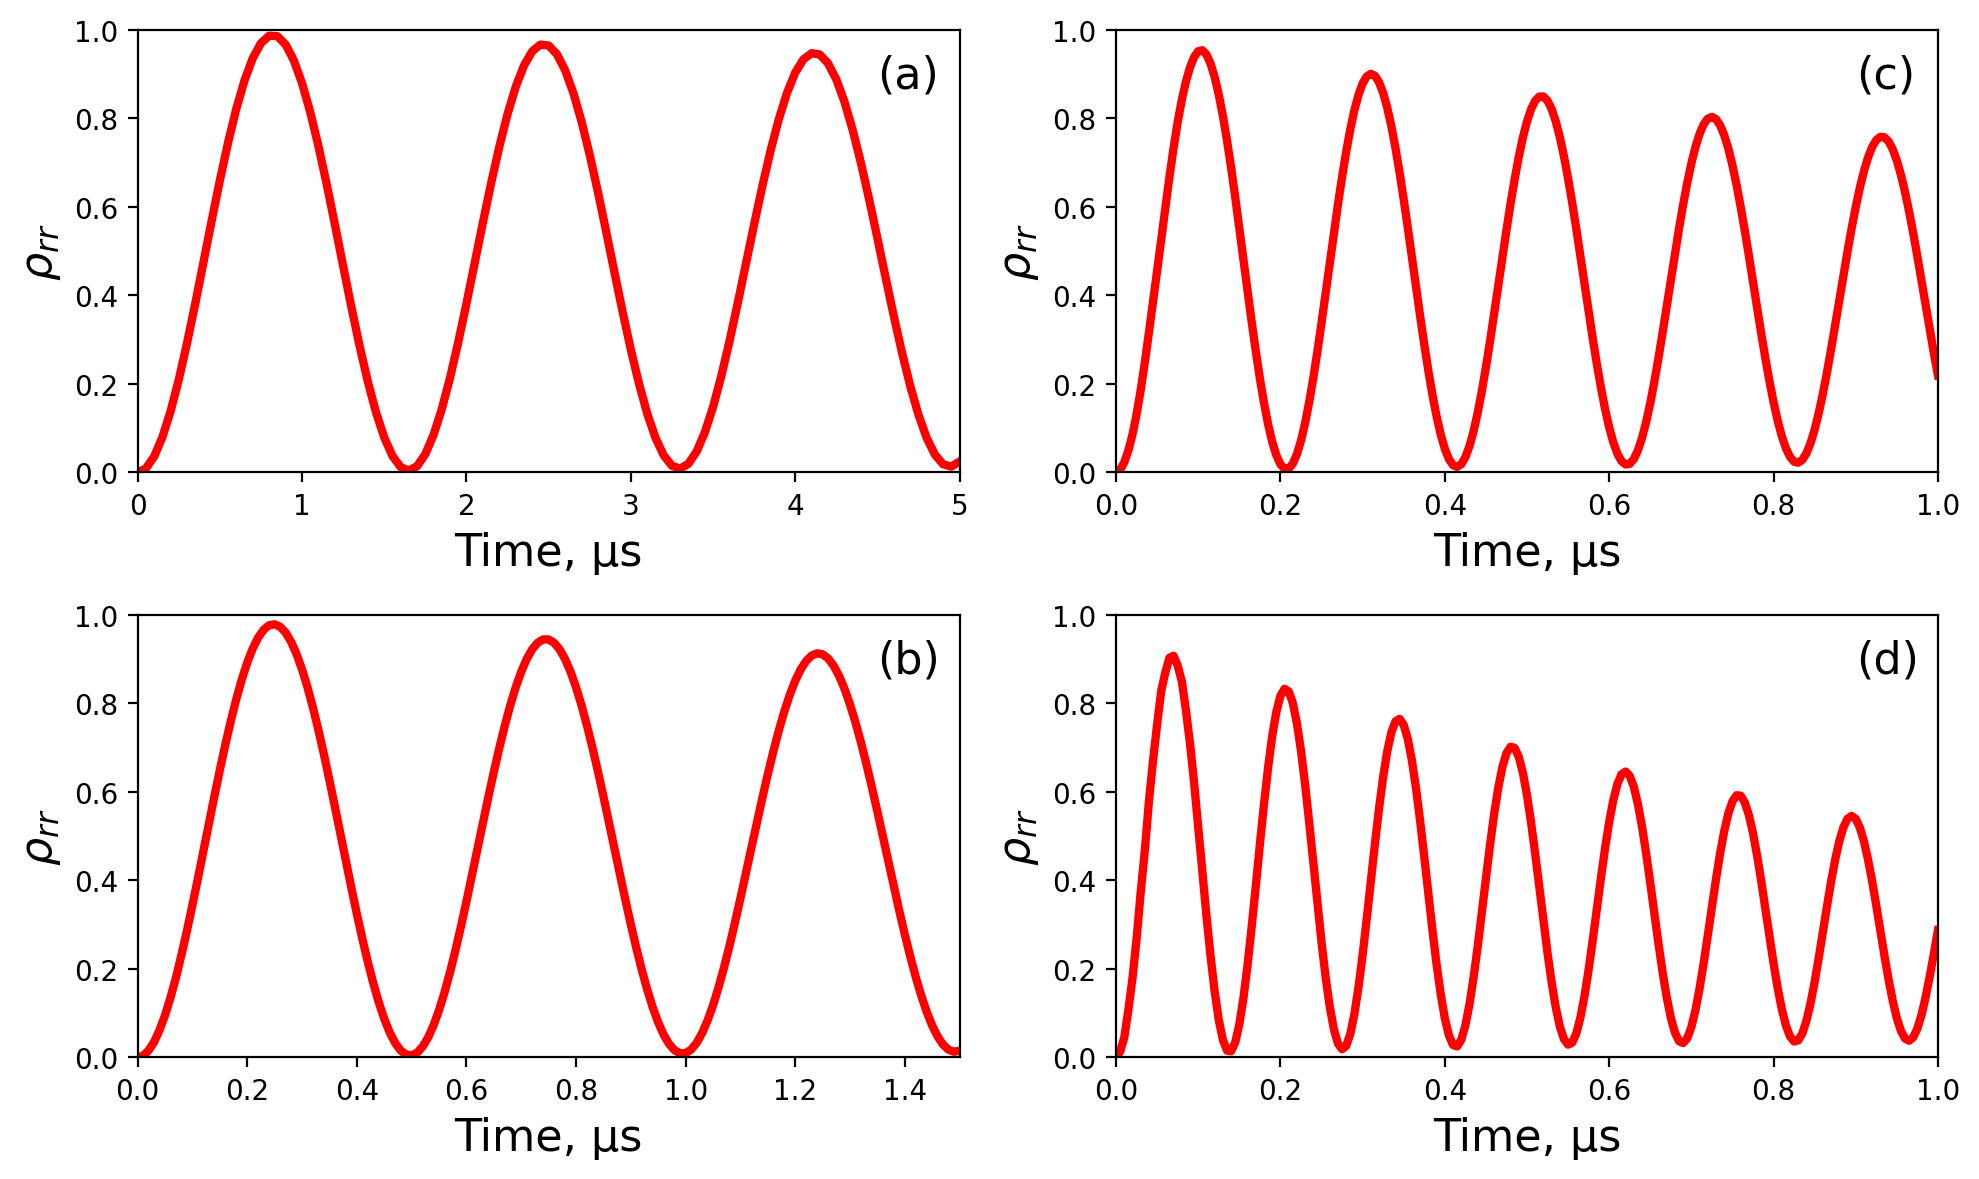

In [197]:
linewidth = 3.0;
fontsize = 16.0;

figure(figsize=(10,6), dpi=200)

subplot(221)
plot(tspan_a, expect(nr, ρ_mean_a), color="red", linewidth=linewidth)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_a))
ylim(0.0, 1.0)
text(maximum(tspan_a)*9/10, 0.87, "(a)", fontsize=fontsize)


subplot(222)
plot(tspan_cd, expect(nr, ρ_mean_c), color="red", linewidth=linewidth)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_cd))
ylim(0.0, 1.0)
text(maximum(tspan_cd)*9/10, 0.87, "(c)", fontsize=fontsize)


subplot(223)
plot(tspan_b, expect(nr, ρ_mean_b), color="red", linewidth=linewidth)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_b))
ylim(0.0, 1.0)
text(maximum(tspan_b)*9/10, 0.87, "(b)", fontsize=fontsize)


subplot(224)
plot(tspan_cd, expect(nr, ρ_mean_d), color="red", linewidth=linewidth)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_cd))
ylim(0.0, 1.0)
text(maximum(tspan_cd)*9/10, 0.87, "(d)", fontsize=fontsize)

tight_layout()
# savefig("../notebooks/images/Simulator_Fig6.jpg", dpi=300)
gcf()

#### Figure 8(b): Including all effects in the simulation.

- Not actually figure 8 in sense that spatial&velocity decoherence is a bit different due to different excitation beam configuration(antiparallel) + different spontaneous decay branching ratios.

- Laser noise is taken from Saffman

- Not sure that the simulation is correct. $\delta$ is not scanned in the simulation, while resonant value might not coincide with the theoretical $\frac{\Omega_b^2 - \Omega_r^2}{4\Delta}$. The larger the correction to $\delta$, the less accurate it is(I think so)


__Sources of decoherence:__

- Dashed-dotted: Doppler

- Dashed: Spontaneous

- Dotted: Laser-noise

- Solid black: All

- Red: All + Finite contrast(Maximum not shifted)

<img src="../notebooks/images/Browayes_Fig8.png" alt="drawing" width="500"/>


##### Parallel lasers. 5 $\mu m$ excitation beam waists. 

In [582]:
"""
- Parameters simillar to Browayes, parallel red and blue laser 

- Laser noise is taken from Saffman.
"""
#Saffman params for laser phase noise
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 10.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
# fg2 = 234.0 * 1e-3; #MHz
fg2 = 1.0; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];

f = [0.01:0.0025:1.0;];
red_laser_phase_amplitudes = ϕ_amplitudes(f, red_laser_phase_params);
blue_laser_phase_amplitudes = ϕ_amplitudes(f, blue_laser_phase_params);


#Excitation beam parameters
λr = 0.795;
λb = 0.475;

"""
In the article beams are actually elliptical with (wx, wy) 
for red and blue beams equal to (24, 50) and (50, 200) μm.
"""
wr = 5.0;
wb = 5.0;
zr = w0_to_z0(wr, λr);
zb = w0_to_z0(wr, λb);

U0 = 1000.0;
w0 = 1.1;
λ0 = 0.852;
z0 = w0_to_z0(w0, λ)
kT = 50.0;

atom_params = [m, kT];
trap_params = [U0, w0, z0];

#Samples
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);


#Rabi frequencies
Δ0 = 2.0*π * 740.0;
Ωb = 2π * 35.0;
blue_laser_params = [Ωb, wb, zb];
Γ = 2.0*π * 6.0;
decay_params = [Γ/3, 2*Γ/3];

# Ω_list = 2.0*π * [0.25, 0.5, 1.0, 2.0, 4.0, 6.0, 10.0];
Ω_list = 2.0*π * [0.95, 0.975, 1.0, 1.025, 1.05];
Ωr_list = Ωr_required(Ω_list, Ωb, Δ0); 
T_list = T_twophoton(Ωr_list, Ωb, Δ0);

In [479]:
Results
max_amplitude            = []; #Total
decay_amplitude          = []; #Only spontaneous decay
dynamics_amplitude       = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude          = []; #Only laser noise

max_amplitude_error      = []; #Total
decay_amplitude_error    = []; #Only spontaneous decay
dynamics_amplitude_error = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude_error    = []; #Only laser noise


#Total
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        laser_noise=true,
        spontaneous_decay=true,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(max_amplitude, ρrr[max_idx]);
    append!(max_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Decay
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=false,
        laser_noise=false,
        spontaneous_decay=true,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(decay_amplitude, ρrr[max_idx]);
    append!(decay_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Atom motion
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(dynamics_amplitude, ρrr[max_idx]);
    append!(dynamics_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Laser noise
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=false,
        laser_noise=true,
        spontaneous_decay=false,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(noise_amplitude, ρrr[max_idx]);
    append!(noise_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

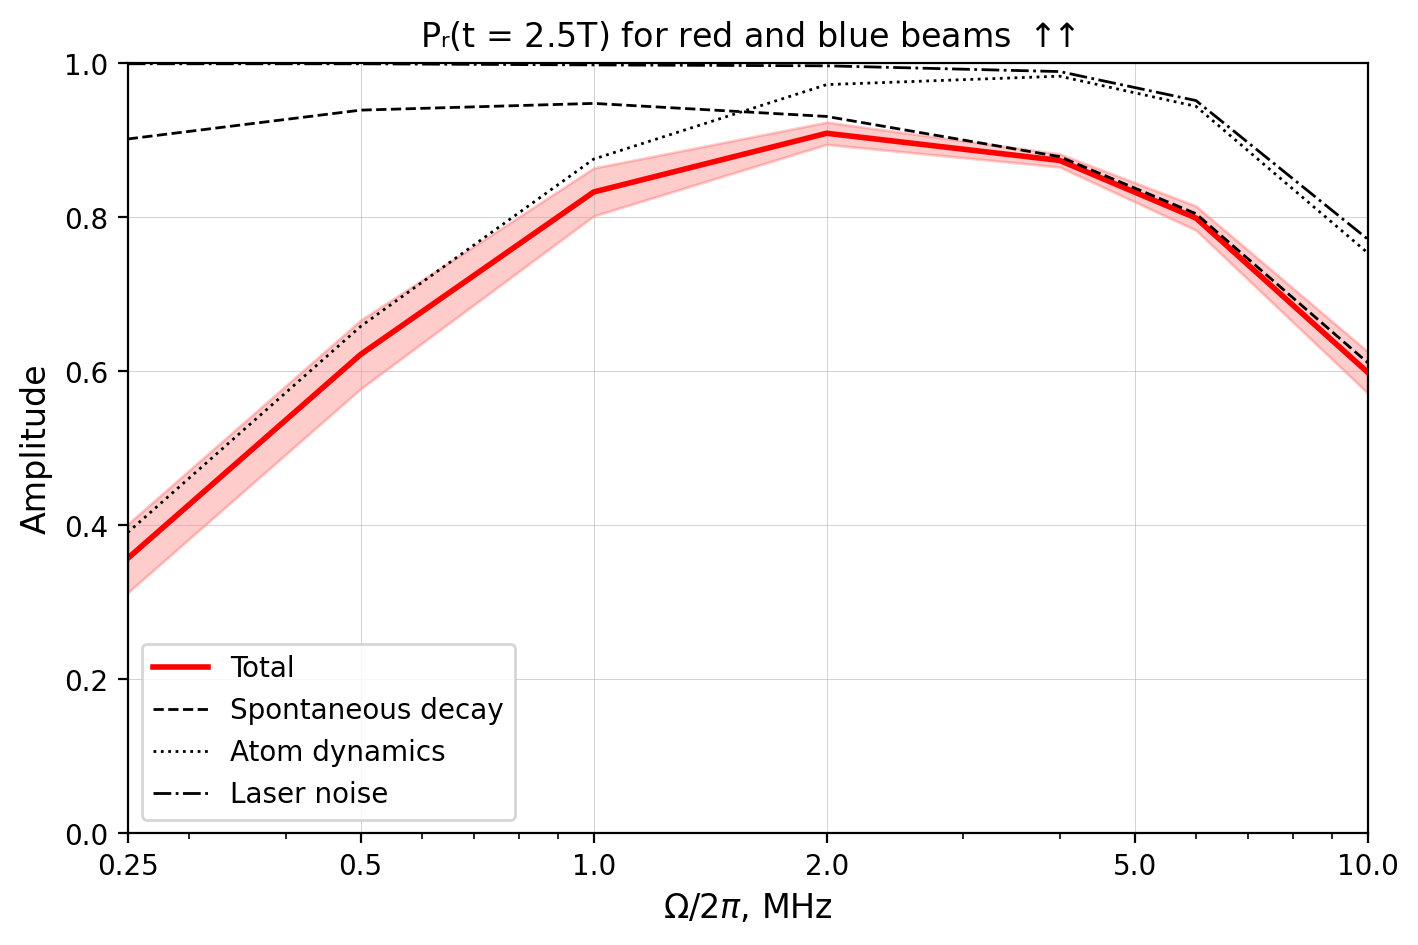

In [505]:
linewidth=2.0
fontsize=12

figure(figsize=(8, 5), dpi=200)
plot(Ω_list ./ (2.0 * π), max_amplitude, color="red", linestyle="solid", linewidth=linewidth, label="Total")
fill_between(Ω_list ./ (2.0 * π), max_amplitude - max_amplitude_error, max_amplitude + max_amplitude_error,
            color="red", alpha=0.2)
plot(Ω_list ./ (2.0 * π), decay_amplitude, color="black", linewidth=linewidth/2, linestyle="dashed", label="Spontaneous decay")
plot(Ω_list ./ (2.0 * π), dynamics_amplitude, color="black", linewidth=linewidth/2, linestyle="dotted", label="Atom dynamics")
plot(Ω_list ./ (2.0 * π), noise_amplitude, color="black", linewidth=linewidth/2, linestyle="dashdot", label="Laser noise")

xlabel("\$ \\Omega / 2\\pi \$, MHz", fontsize=fontsize)
ylabel("Amplitude", fontsize=fontsize)

xlim(minimum(Ω_list)/ (2.0 * π), maximum(Ω_list)/ (2.0 * π))
ylim(0.0, 1.0)
grid(true, linewidth=0.2)

xscale("log")
xticks(
    ticks=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
    labels=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])

legend()
title("Pᵣ(t = 2.5T) for red and blue beams \$ \\uparrow \\! \\! \\! \\uparrow  \$")
# savefig("../notebooks/images/total_5mum_parallel.pdf", dpi=300)
gcf()



##### Antiparallel beams with 10 $ \mu m $ waists. Laser phase noise at 1.0MHz + larger noise amplitude. 

In [601]:
#Saffman params for laser phase noise
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e4 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 1.0; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 5.0 * 1e-3;   #MHz

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];

f = [0.01:0.005:5.0;];
red_laser_phase_amplitudes = ϕ_amplitudes(f, red_laser_phase_params);
blue_laser_phase_amplitudes = ϕ_amplitudes(f, blue_laser_phase_params);


#Excitation beam parameters
λr = 0.795;
λb = 0.475;
#Excitation beam parameters
λr = 0.795;
λb = 0.475;

"""
In the article beams are actually elliptical with (wx, wy) 
for red and blue beams equal to (24, 50) and (50, 200) μm.
"""
wr = 10.0;
wb = 10.0;
zr = w0_to_z0(wr, λr);
zb = w0_to_z0(wr, λb);

U0 = 1000.0;
w0 = 1.1;
λ0 = 0.852;
z0 = w0_to_z0(w0, λ)
kT = 50.0;

atom_params = [m, kT];
trap_params = [U0, w0, z0];

#Samples
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);


#Rabi frequencies
Δ0 = 2.0*π * 740.0;
Ωb = 2π * 35.0;
blue_laser_params = [Ωb, wb, zb];
Γ = 2.0*π * 6.0;
decay_params = [Γ/3, 2*Γ/3];

Ω_list = 2.0*π * [0.25, 0.5, 1.0, 2.0, 4.0, 6.0, 10.0];
Ωr_list = Ωr_required(Ω_list, Ωb, Δ0); 
T_list = T_twophoton(Ωr_list, Ωb, Δ0);

In [603]:
#Results
# max_amplitude            = []; #Total
# decay_amplitude          = []; #Only spontaneous decay
# dynamics_amplitude       = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude          = []; #Only laser noise

nothing_amplitude = [];

# max_amplitude_error      = []; #Total
# decay_amplitude_error    = []; #Only spontaneous decay
# dynamics_amplitude_error = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude_error    = []; #Only laser noise
nothing_amplitude_error = [];


# #Total
# for i ∈ 1:length(Ω_list)
#     red_laser_params = [Ωr_list[i], wr, zr];
#     δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
#     detuning_params = [Δ0, δ0];
    
#     T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
#     tspan = 2.5 * T0 * [0.98:0.005:1.02;];
#     pushfirst!(tspan, 0.0)

#     ρ_mean, ρ2_mean = simulation(
#         tspan, ψ0, 
        
#         samples,
        
#         f,
#         red_laser_phase_amplitudes,
#         blue_laser_phase_amplitudes,
        
#         red_laser_params,
#         blue_laser_params,
        
#         detuning_params,
#         decay_params;
#         atom_motion=true,
#         laser_noise=true,
#         spontaneous_decay=true,
#         parallel=false
#     );
    
#     ρrr = real(expect(nr, ρ_mean))[2:end];
#     ρrr2 = real(expect(nr, ρ2_mean))[2:end];

#     max_idx = argmax(ρrr);
#     append!(max_amplitude, ρrr[max_idx]);
#     append!(max_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
# end;

# #Decay
# for i ∈ 1:length(Ω_list)
#     red_laser_params = [Ωr_list[i], wr, zr];
#     δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
#     detuning_params = [Δ0, δ0];
    
#     T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
#     tspan = 2.5 * T0 * [0.98:0.005:1.02;];
#     pushfirst!(tspan, 0.0)

#     ρ_mean, ρ2_mean = simulation(
#         tspan, ψ0, 
        
#         samples,
        
#         f,
#         red_laser_phase_amplitudes,
#         blue_laser_phase_amplitudes,
        
#         red_laser_params,
#         blue_laser_params,
        
#         detuning_params,
#         decay_params;
#         atom_motion=false,
#         laser_noise=false,
#         spontaneous_decay=true,
#         parallel=false
#     );
    
#     ρrr = real(expect(nr, ρ_mean))[2:end];
#     ρrr2 = real(expect(nr, ρ2_mean))[2:end];

#     max_idx = argmax(ρrr);
#     append!(decay_amplitude, ρrr[max_idx]);
#     append!(decay_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
# end;

# #Atom motion
# for i ∈ 1:length(Ω_list)
#     red_laser_params = [Ωr_list[i], wr, zr];
#     δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
#     detuning_params = [Δ0, δ0];
    
#     T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
#     tspan = 2.5 * T0 * [0.98:0.005:1.02;];
#     pushfirst!(tspan, 0.0)

#     ρ_mean, ρ2_mean = simulation(
#         tspan, ψ0, 
        
#         samples,
        
#         f,
#         red_laser_phase_amplitudes,
#         blue_laser_phase_amplitudes,
        
#         red_laser_params,
#         blue_laser_params,
        
#         detuning_params,
#         decay_params;
#         atom_motion=true,
#         laser_noise=false,
#         spontaneous_decay=false,
#         parallel=false
#     );
    
#     ρrr = real(expect(nr, ρ_mean))[2:end];
#     ρrr2 = real(expect(nr, ρ2_mean))[2:end];

#     max_idx = argmax(ρrr);
#     append!(dynamics_amplitude, ρrr[max_idx]);
#     append!(dynamics_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
# end;

#Laser noise

for i ∈ 1:length(Ω_list)
    for j ∈ 1:length(_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=false,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=false
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(nothing_amplitude, ρrr[max_idx]);
    append!(nothing_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

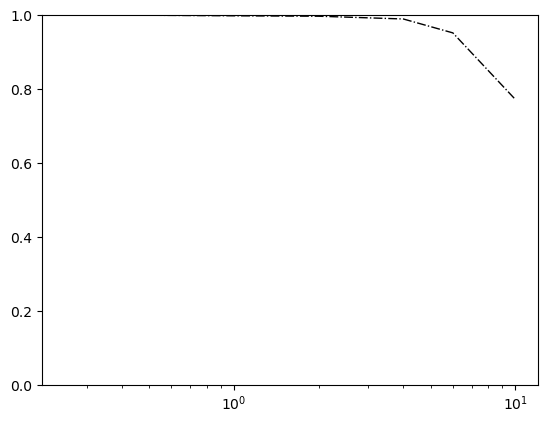

In [606]:
figure()
plot(Ω_list ./ (2.0 * π), nothing_amplitude, color="black", linewidth=linewidth/2, linestyle="dashdot", label="Laser noise")
xscale("log")
# xticks(
#     ticks=[],
#     labels=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])
ylim(0.0, 1.0)
gcf()

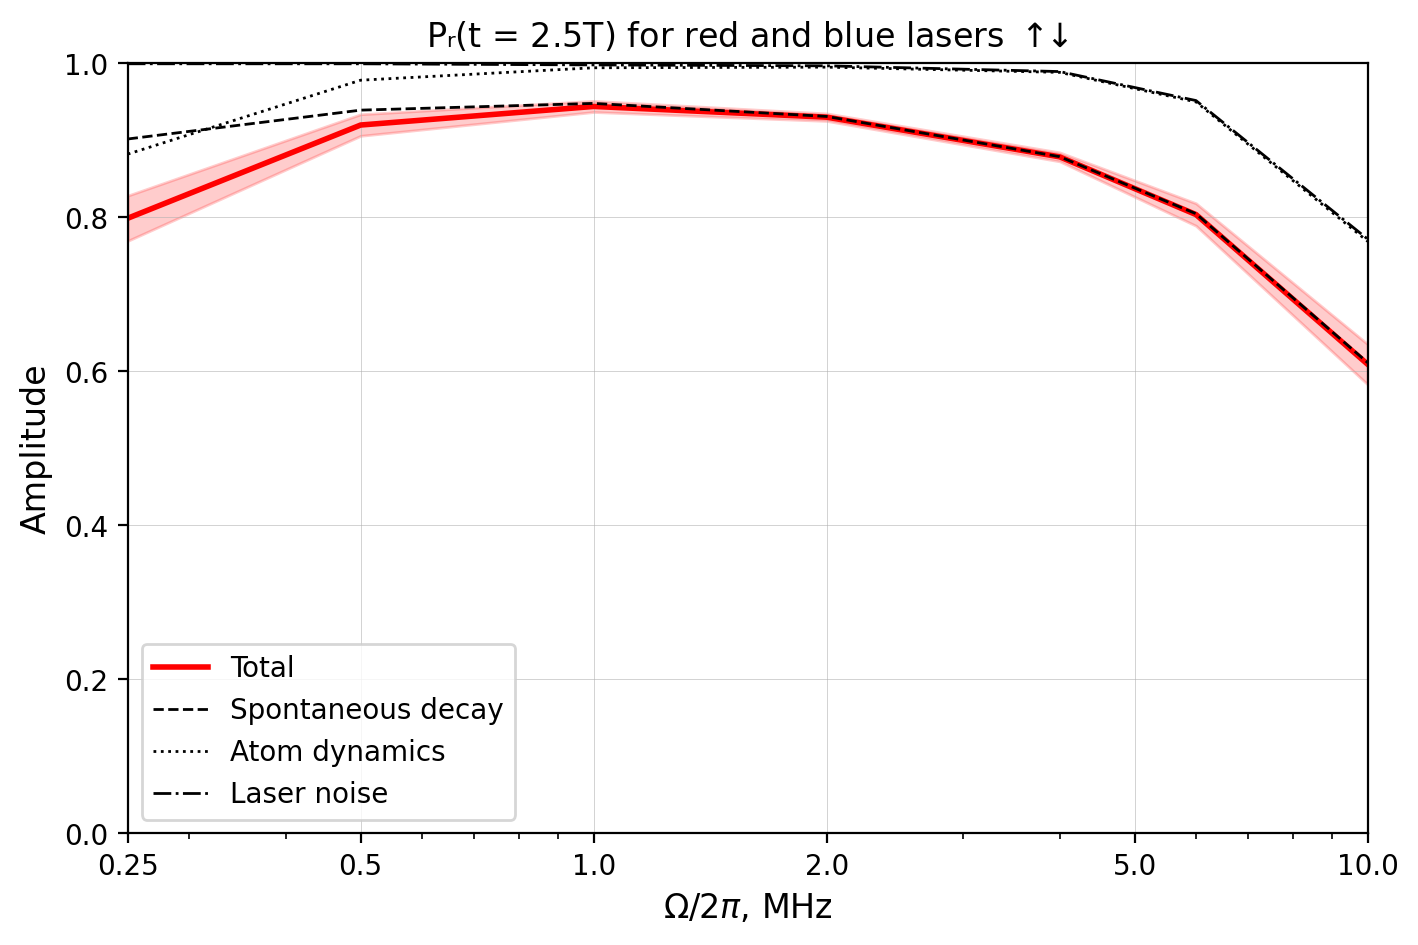

In [515]:
linewidth=2.0
fontsize=12

figure(figsize=(8, 5), dpi=200)
plot(Ω_list ./ (2.0 * π), max_amplitude, color="red", linestyle="solid", linewidth=linewidth, label="Total")
fill_between(Ω_list ./ (2.0 * π), max_amplitude - max_amplitude_error, max_amplitude + max_amplitude_error,
            color="red", alpha=0.2)
plot(Ω_list ./ (2.0 * π), decay_amplitude, color="black", linewidth=linewidth/2, linestyle="dashed", label="Spontaneous decay")
plot(Ω_list ./ (2.0 * π), dynamics_amplitude, color="black", linewidth=linewidth/2, linestyle="dotted", label="Atom dynamics")
plot(Ω_list ./ (2.0 * π), noise_amplitude, color="black", linewidth=linewidth/2, linestyle="dashdot", label="Laser noise")

xlabel("\$ \\Omega / 2\\pi \$, MHz", fontsize=fontsize)
ylabel("Amplitude", fontsize=fontsize)

xlim(minimum(Ω_list)/ (2.0 * π), maximum(Ω_list)/ (2.0 * π))
ylim(0.0, 1.0)
grid(true, linewidth=0.2)

xscale("log")
xticks(
    ticks=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
    labels=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])

legend()
title("Pᵣ(t = 2.5T) for red and blue lasers \$ \\uparrow \\! \\! \\! \\downarrow  \$")
savefig("../notebooks/images/total_10mum_antiparallel_evenmorenoise_1MHz.pdf", dpi=300)
gcf()



#### 2D Heatmapl, $(\Delta, \Omega_r)$

In [ ]:
"""
- Parameters simillar to Browayes, parallel red and blue laser 

- Laser noise is taken from Saffman.
"""
#Saffman params for laser phase noise
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 10.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 1.0; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];

f = [0.01:0.0025:1.0;];
red_laser_phase_amplitudes = ϕ_amplitudes(f, red_laser_phase_params);
blue_laser_phase_amplitudes = ϕ_amplitudes(f, blue_laser_phase_params);


#Excitation beam parameters
λr = 0.795;
λb = 0.475;

"""
In the article beams are actually elliptical with (wx, wy) 
for red and blue beams equal to (24, 50) and (50, 200) μm.
"""
wr = 5.0;
wb = 5.0;
zr = w0_to_z0(wr, λr);
zb = w0_to_z0(wr, λb);

U0 = 1000.0;
w0 = 1.1;
λ0 = 0.852;
z0 = w0_to_z0(w0, λ)
kT = 50.0;

atom_params = [m, kT];
trap_params = [U0, w0, z0];

#Samples
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);


#Rabi frequencies
Δ0 = 2.0*π * 740.0;
Ωb = 2π * 35.0;
blue_laser_params = [Ωb, wb, zb];
Γ = 2.0*π * 6.0;
decay_params = [Γ/3, 2*Γ/3];

# Ω_list = 2.0*π * [0.25, 0.5, 1.0, 2.0, 4.0, 6.0, 10.0];
Ω_list = 2.0*π * [0.95, 0.975, 1.0, 1.025, 1.05];
Ωr_list = Ωr_required(Ω_list, Ωb, Δ0); 
T_list = T_twophoton(Ωr_list, Ωb, Δ0);

In [ ]:
Results
max_amplitude            = []; #Total
decay_amplitude          = []; #Only spontaneous decay
dynamics_amplitude       = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude          = []; #Only laser noise

max_amplitude_error      = []; #Total
decay_amplitude_error    = []; #Only spontaneous decay
dynamics_amplitude_error = []; #Only atom dynamics: doppler + spatial distribution
noise_amplitude_error    = []; #Only laser noise


#Total
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        laser_noise=true,
        spontaneous_decay=true,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(max_amplitude, ρrr[max_idx]);
    append!(max_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Decay
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=false,
        laser_noise=false,
        spontaneous_decay=true,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(decay_amplitude, ρrr[max_idx]);
    append!(decay_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Atom motion
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(dynamics_amplitude, ρrr[max_idx]);
    append!(dynamics_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

#Laser noise
for i ∈ 1:length(Ω_list)
    red_laser_params = [Ωr_list[i], wr, zr];
    δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
    detuning_params = [Δ0, δ0];
    
    T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
    tspan = 2.5 * T0 * [0.98:0.005:1.02;];
    pushfirst!(tspan, 0.0)

    ρ_mean, ρ2_mean = simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=false,
        laser_noise=true,
        spontaneous_decay=false,
        parallel=true
    );
    
    ρrr = real(expect(nr, ρ_mean))[2:end];
    ρrr2 = real(expect(nr, ρ2_mean))[2:end];

    max_idx = argmax(ρrr);
    append!(noise_amplitude, ρrr[max_idx]);
    append!(noise_amplitude_error, sqrt(ρrr2[max_idx] - ρrr[max_idx] ^2) / sqrt(N));
end;

__Comments on Browayes article:__

1. Not sure that theorethical compensation of $\delta$ for non-equal rabi frequencies is exact. Better way is to scan across this theorethical prediction as the two-photon resonance is narrow. Sources of decoherence and decay can also shift resonance condition slightly.

2. No accout for multiple intermediate levels. Those states are dark to blue laser, so they trap population -> same effect as spontaneous decay.

3. It's strange that Rydberg lifetime doesn't account to decoherence. This state is populated, so it should give significant contribution to decay.

4. For big two-photon Rabi frequencies off-resonance $\delta$ scales $\sim \Omega_r^2$. In Browayes setup only Doppler accounts, in our setup atom distribution is also important.


__Other ideas:__

1. Main problems are atom temperature and spatial spread. PGD + wider beams should help.

2. We are limited by blue laser power because there are no high-power blue lasers. 

- no parallel operations, can image only 2 atoms

- can't make high Rabi frequencies

- can't make wider beams, alternative for close spacing of atoms is distant spacing + transportation

- _Solution:_ Precilasers $\sim 1080$ nm


__Modelling for our system (__Is laser noise that important?__):__

- Extract trap depth from AC Stark $\rightarrow U_0$

- Extract trap parameters from parametric resonance by calculating difference between peaks $\rightarrow w_0$

- Extract temperature from release&recapture $\rightarrow T$

- Check that parametric resonance is well approximated by modelling with extracted $(U_0, w_0, T)$

- Extract Rabi frequency for blue laser by measuring Stark shift $\rightarrow \Omega_b$

- Calculate Rabi frequency for red laser from two-photon theory $\rightarrow \Omega_r$

- Fit single-Rydberg oscillations by parameter-free simulation without laser noise. Good fit -> don't need to improve laser.


__Ideas for improvement__

0. Julia has its own function profiler https://www.julia-vscode.org/docs/stable/userguide/profiler/ , https://docs.julialang.org/en/v1/stdlib/Profile/



1. Replace [t->Ω(t), t->Ω(t)], [σab, σba] with single operator.



2. Try to include detuning fluctuations into phase noise, less time-dependent terms in hamiltonian.



3. Check time it takes to run interpolation of phase noise and compare it w/o interpolation.



4. Maybe there are some recepies in Bloqade.jl how to speed up code.

In [441]:
i = 1;
red_laser_params = [Ωr_list[i], wr, zr];
δ0 = δ_twophoton(Ωr_list[i], Ωb, Δ0);
detuning_params = [Δ0, δ0];

T0 = T_twophoton(Ωr_list[i], Ωb, Δ0);
tspan = 2.5 * T0 * [0.98:0.005:1.02;];
pushfirst!(tspan, 0.0)

ρ_mean, ρ2_mean = simulation(
    tspan, ψ0, 
    
    samples,
    
    f,
    red_laser_phase_amplitudes,
    blue_laser_phase_amplitudes,
    
    red_laser_params,
    blue_laser_params,
    
    detuning_params,
    decay_params;
    atom_motion=true,
    laser_noise=true,
    spontaneous_decay=true,
    parallel=true
);

ρrr = real(expect(nr, ρ_mean))[2:end];
ρrr2 = real(expect(nr, ρ2_mean))[2:end];

max_idx = argmax(ρrr);

In [572]:
#Saffman params for laser phase noise
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 5.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 1.0; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.0 * 1e-3;   #MHz

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];

f = [0.01:0.005:5.0;];

dt_noise = 0.1 / maximum(f);
tspan_noise = [0.0:0.025:2.0;];


#Generate phase noise traces for red and blue lasers
ϕ_red_res = ϕ(tspan_noise, f, red_laser_phase_amplitudes);
ϕ_blue_res = ϕ(tspan_noise, f, blue_laser_phase_amplitudes);

#Interpolate phase noise traces to pass to hamiltonian
nodes = (tspan_noise, );
ϕ_red = interpolate(nodes, ϕ_red_res, Gridded(Linear()));
ϕ_blue = interpolate(nodes, ϕ_blue_res, Gridded(Linear()));

In [1]:
Threads.nthreads()

2

In [1]:
Threads.nthreads()

1